In [89]:
import os
import sys
import pandas as pd
import numpy as np

import warnings

# warnings.filterwarnings('error')
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import com_func

#----- threshold for selecting set of name group -----------#
threshold_select_name_group = 100
#----- threshold for selecting min sample in name group ----#
threshold_lower = 50
threshold_upper = 60

apply_threshold_to_sample = True

pp_textual = ["lsa", "pv_dm", "pv_dbow"]
pp_citation = "n2v"

Dataset = "pubmed"

In [3]:
def read_file(infile):
    AllRecords_original = []
    with open(infile, 'r', encoding = 'utf8') as f:
        for line in f:
            read_data = line.split("\t")
            # get ride of bad formated lines
            if(len(read_data)==13 or len(read_data)==12):
                paper_detail = {"paperID": read_data[0], "authorID":read_data[1]}
                AllRecords_original.append(paper_detail)
            else:
                print(len(read_data))
        f.close()
    return pd.DataFrame(AllRecords_original)

In [90]:
def extract_embedding(all_embedding, wanted_pid_list):
    extracted_emb = []
    wanted_pid_list = wanted_pid_list.values.tolist()
    wanted_pid_list = [int(x) for x in wanted_pid_list]
    wanted_pid_list = list(sorted(set(wanted_pid_list)))
    total_missing_sample = 0
    # only if embedding exist
    if len(all_embedding)>0:
        # loop through wanted pid list to keep input order
        for embedding in all_embedding:
            if(len(wanted_pid_list)==0):
                break
            while (wanted_pid_list[0]<=int(embedding[0])):
                if wanted_pid_list[0]==int(embedding[0]):
                    extracted_emb.append(embedding)
                    wanted_pid_list.remove(int(embedding[0]))
                elif (wanted_pid_list[0]<int(embedding[0])):
                    total_missing_sample+=1
                    # ------------------------ fill it up with 0's -------------------------- #
                    fill_na = [wanted_pid_list[0]]
                    temp = [0] * (len(all_embedding[0])-1)
                    final_filled_zero_emb = fill_na+temp
                    extracted_emb.append(final_filled_zero_emb)
                    # ----- or do nothing and remove those missing samples from dataset ----- #
                    # remove paper that not in all dataset
                    wanted_pid_list.remove(wanted_pid_list[0])
                if len(wanted_pid_list)==0:
                    break
    print("Total missing sample: ", total_missing_sample)
    extracted_emb = pd.DataFrame(extracted_emb)
    return extracted_emb

In [91]:
# collect unlabeled vectors
def extract_unlabeled_embedding(allembedding, unlabeled_pid):
    unlabeled_pid = [int(x) for x in unlabeled_pid]
    unlabeled_pid = list(sorted(set(unlabeled_pid)))
    wanted_embedding = []
    for embedding in allembedding:
        if(len(unlabeled_pid)==0):
            break
        while (unlabeled_pid[0]<=int(embedding[0])):
            if unlabeled_pid[0]==int(embedding[0]):
                wanted_embedding.append(embedding)
                unlabeled_pid.remove(int(embedding[0]))
            elif (unlabeled_pid[0]<int(embedding[0])):
                # remove paper that not in all dataset
                unlabeled_pid.remove(unlabeled_pid[0])
            if len(unlabeled_pid)==0:
                break
    unlabeled_data = pd.DataFrame(wanted_embedding)
    unlabeled_data['label'] = "-1"
    unlabeled_data = unlabeled_data.rename(columns={0: 'paperID'})
    return unlabeled_data

In [92]:
# some of the record doesn't have citation links, therefore we will have to remove those papers from train and test set
# synchronize data wrt pid
def synchro_views(labeled_dv1, labeled_dv2, unlabeled_data1, unlabeled_data2):
    noCitationPids_labeled = set(labeled_dv1[0])-set(labeled_dv2[0])
    print("labeled no citation link: ", len(noCitationPids_labeled))
    noCitationPids_unlabeled = set(unlabeled_data1['paperID'])-set(unlabeled_data2['paperID'])
    print("Unlabeled no citation link size: ", len(noCitationPids_unlabeled))
    # process unlabeled data
    unlabeled_dv1 = unlabeled_data1[~unlabeled_data1['paperID'].isin(noCitationPids_unlabeled)].reset_index(drop=True)
    unlabeled_dv2 = unlabeled_data2
    # process labeled data
    labeled_dv1_final = labeled_dv1[~labeled_dv1[0].isin(noCitationPids_labeled)].reset_index(drop=True)
    labeled_dv2_final = labeled_dv2
    # since our input data are sorted, all data are in order with pid
    return labeled_dv1_final, labeled_dv2_final, unlabeled_dv1, unlabeled_dv2

In [93]:
# remove author(positive sample) from other(negative sample)
import random
def extractNegativeSample(positiveSample, allSample):
    negativeSample = [x for x in allSample if x not in positiveSample]
    return negativeSample

In [103]:
import numpy as np
import warnings
import matplotlib.pyplot as plt

# create co training classifier
class Co_training_clf(object):
    
    import copy
    
    def __init__(self, clf1, clf2=None, p=1, n=1, k=30, u = 75):
        
        self.clf1 = clf1
        # assume co_training on one classifier
        if clf2 == None:
            self.clf2 = self.copy.copy(clf1)
        else:
            self.clf2 = clf2
        # take p example from most confidently positive labels to example
        self.p = p
        # take n example from most confidently negative label to example
        self.n = n
        # number of iteration
        self.k = k
        # size of pool of unlabeled samples
        self.u = u
        # index of positive labeled samples
        self.new_labeled_pos = []
        # index of negative labeled samples
        self.new_labeled_neg = []
        # when fit co-train, we collect f1 on test samples wrt each iteration
        self.f1_on_test_dv1 = []
        self.f1_on_test_dv2 = []

    def init_L_U_U_prime(self, labels):
        # index of the samples that are initially labeled
        L = [i for i, label_i in enumerate(labels) if label_i != -1]
        # index of unlabeled samples
        U = [i for i, label_i in enumerate(labels) if label_i == -1]
        print("Initial L size: ", len(L))
        print("Initial U size: ", len(U))
        # random drawing sample from U
        random.shuffle(U)
        U_prime = U[-min(len(U), self.u):]
        # remove the samples in U_prime from U
        U = U[:-len(U_prime)]
        return L, U, U_prime

    def label_p_n_samples(self, proba, rank):
        U_prime_size = len(proba)
        print(U_prime_size)
        p, n = [], []
        for label, conf_measure in enumerate(rank):
            # 0 positive sample
            if label==0:
                index = 0
                while(len(p) < self.p):
                    max_conf_sample_index = conf_measure[index]
                    # ---- if positive predict proba is more than 50% ------- #
                    if (proba[max_conf_sample_index][label] > 0.5):
                        print('P: ', max_conf_sample_index, " : ", proba[max_conf_sample_index])
                        p.append(max_conf_sample_index)
                    index +=1
                    if (index>=U_prime_size):
                        break
            # 1 negative sample
            elif label == 1:
                index = 0
                while(len(n) < self.n):
                    max_conf_sample_index = conf_measure[index]
                    # ---- if negative predict proba is more than 50% ------- #
                    if (proba[max_conf_sample_index][label] > 0.5):
                        print('N: ', max_conf_sample_index, " : ", proba[max_conf_sample_index])
                        n.append(max_conf_sample_index)
                    index +=1
                    if (index>=U_prime_size):
                        break
            else:
                print("Class label error")
        return p, n

    def get_self_labeled_sample(self):
        '''
        return:
            self-labeled new positive, self-labeled new negative (Index), all self_labeled_sample_size
        '''
        all_new_data = self.new_labeled_pos+self.new_labeled_neg
        
        return self.new_labeled_pos, self.new_labeled_neg, len(all_new_data)

    def plot_co_training_process(self, iterCount, data, label, plotSavingPath, name):
        if not os.path.exists(plotSavingPath):
            os.makedirs(plotSavingPath)
        # apply PCA on input data
        pca = PCA(n_components=2)
        pca_transformed = pca.fit_transform(X=data)
        pca_one = pca_transformed[:,0]
        pca_two = pca_transformed[:,1]
        # plot the result
        fig, ax = plt.subplots(figsize=(9,7))
        for author in np.unique(label):
            ix = np.where(label == author)
            ax.scatter(pca_one[ix], pca_two[ix], cmap='viridis', label = author, s = 50)
        ax.legend()
        plt.title('Co-training iteration: '+ str(iterCount))
        plt.xlabel("PCA one")
        plt.ylabel("PCA two")
        plt.savefig((plotSavingPath+name+"_PCA_i-"+str(iterCount)+".png").encode('utf-8'), dpi=100)
        plt.close()
        # plt.show()
        

    def fit(self, dataView1, dataView2, labels, dv1_test, dv2_test, label_test, plot_save_name=None, plot_save_path=None):
        
        labels = np.asarray(labels, dtype='int32')
        print("P value: ", self.p, " N value: ", self.n)
        
        L, U, U_prime = self.init_L_U_U_prime(labels)
        
        iterCount = 0
        #loop until we have assigned labels to every sample in U and U_prime or we hit our iteration break condition
        while iterCount < self.k and U_prime:
#             print("step",iterCount, " L: ",L)
#             print("step",iterCount, " U_prime: ",U_prime)
            iter_train_d1 = dataView1.iloc[L]
            iter_train_d2= dataView2.iloc[L]
            iter_train_label = labels[L]
            # ----------- plot the co-training process -------------- #
            if plot_save_name != None:
                # ----- save pca reduced plot for dv1 ------ #
                plot_save_dv1_name = plot_save_name+"_dv1"
                self.plot_co_training_process(iterCount, iter_train_d1, iter_train_label, plot_save_path, plot_save_dv1_name)
                # ----- dv2 -------- #
                plot_save_dv2_name = plot_save_name+"_dv2"
                self.plot_co_training_process(iterCount, iter_train_d2, iter_train_label, plot_save_path, plot_save_dv2_name)
            self.clf1.fit(iter_train_d1, iter_train_label)
            self.clf2.fit(iter_train_d2, iter_train_label)
            # --------- test error on test data --------------------- #
            # make prediction on test data
            y1 = self.clf1.predict(dv1_test)
            y2 = self.clf2.predict(dv2_test)
            # f1 score on each iteration
            f1_dv1 = f1_score(label_test, y1, average='macro')
            f1_dv2 = f1_score(label_test, y2, average='macro')
            # collect f1 for current iteration
            self.f1_on_test_dv1.append(f1_dv1)
            self.f1_on_test_dv2.append(f1_dv2)
            # ---------- get U_prime sample to be label at ---------- #
            iter_labeling_d1 = dataView1.iloc[U_prime]
            iter_labeling_d2 = dataView2.iloc[U_prime]
            # rank class probabilities for unlabeled sample for it's confidence measure
            dv1_proba = self.clf1.predict_proba(iter_labeling_d1)
            dv2_proba = self.clf2.predict_proba(iter_labeling_d2)
            dv1_proba_rank = []
            dv2_proba_rank = []
            # proba1_rank[i] is label i's confidence measure
            for class_proba in dv1_proba.T:
                dv1_proba_rank.append((-class_proba).argsort())
            for class_proba in dv2_proba.T:
                dv2_proba_rank.append((-class_proba).argsort())
#             print(dv1_proba)
#             print(dv1_proba_rank)
#             print(dv2_proba)
#             print(dv2_proba_rank)
            # h1 classifier
            p1,n1 = self.label_p_n_samples(dv1_proba, dv1_proba_rank)
            # h2 classifier
            p2,n2 = self.label_p_n_samples(dv2_proba, dv2_proba_rank)
            roundP = set(p1+p2)
            roundN = set(n1+n2)
            print("P: ", len(roundP), " N: ", len(roundN))
            print(roundP, roundN)
            # auto label the samples and remove it from U_prime
            auto_labeled_pos = [U_prime[x] for x in roundP]
            auto_labeled_neg = [U_prime[x] for x in roundN]
            auto_labeled_samples = auto_labeled_pos+auto_labeled_neg
            # ---------- collect index of auto_labeled_samples ------------ #
            self.new_labeled_pos.extend(auto_labeled_pos)
            self.new_labeled_neg.extend(auto_labeled_neg)
            
            labels[auto_labeled_pos] = 0
            labels[auto_labeled_neg] = 1
            # extend the labeled sample
            L.extend(auto_labeled_pos)
            L.extend(auto_labeled_neg)
            # remove the labeled sample from U_prime
            U_prime = [x for x in U_prime if x not in auto_labeled_samples]
            #print(U_prime)
            # randomly choice 2p+2n examples from u to replenish u_prime
            replenishItem = U[-(2*self.p+2*self.n):]
            U_prime.extend(replenishItem)
            U = U[:-len(replenishItem)]
            iterCount +=1
        print("Total Labeled number: ", len(L), " Still unlabeled number: ", len(U_prime))
        # final train
        newtrain_d1 = dataView1.iloc[L]
        newtrain_d2 = dataView2.iloc[L]
        self.clf1.fit(newtrain_d1, labels[L])
        self.clf2.fit(newtrain_d2, labels[L])
        # ------ save f1 vs number of iteration plot ------- #
        if plot_save_name != None:
            co_train_text_based = self.f1_on_test_dv1[1:]
            co_train_citation_based = self.f1_on_test_dv2[1:]
            co_training_step = np.arange(1,iterCount)
            default_text_based = [self.f1_on_test_dv1[0]] * iterCount
            default_citation_based = [self.f1_on_test_dv2[0]] * iterCount
            default_step = np.arange(0,iterCount)

            fig = plt.figure()
            ax = plt.axes()
            plt.plot(default_step, default_text_based, linestyle='dashed', label="Text based default")
            plt.plot(default_step, default_citation_based, linestyle='dashdot', label="Citation based default")
            plt.plot(co_training_step, co_train_text_based, linestyle='solid', marker = "*", label="Text based")
            plt.plot(co_training_step, co_train_citation_based, linestyle='dotted', marker = "+", label="Citation based")
            ax.autoscale_view()
            plt.legend()
            plt.xlabel('Co-Training Iterations')
            plt.ylabel('F1 score')
            plt.savefig((plot_save_path+plot_save_name+"_diff_iter_f1.png"), dpi=300)
            plt.show()
            plt.close("all")
    
    def supports_proba(self, clf, x):
        try:
            clf.predict_proba([x])
            return True
        except:
            return False

    def predict(self, dataView1, dataView2):
        y1 = self.clf1.predict(dataView1)
        y2 = self.clf2.predict(dataView2)
        proba_supported = self.supports_proba(self.clf1, dataView1.iloc[0]) and self.supports_proba(self.clf2, dataView2.iloc[0])
        #fill pred with -1 so we can identify the samples in which sample classifiers failed to agree
        y_pred = np.asarray([-1] * dataView1.shape[0])
        for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
            # if both agree on label
            if y1_i == y2_i:
                y_pred[i] = y1_i
            # if disagree on label, times probability together, choice the class have higher probabilities
            elif proba_supported:
                y1_probas = self.clf1.predict_proba([dataView1.iloc[i]])[0]
                y2_probas = self.clf2.predict_proba([dataView2.iloc[i]])[0]
                print("y1 disagree on",i, " Proba: ",y1_probas)
                print("y2 not aggreed on ",i, "Proba: ", y2_probas)
                prod_y_probas = [proba_y1 * proba_y2 for (proba_y1, proba_y2) in zip(y1_probas, y2_probas)]
                print("product probas:",prod_y_probas)
                y_pred[i] = prod_y_probas.index(max(prod_y_probas))
                print("result",y_pred[i])
            else:
                #the classifiers disagree and don't support probability, so we guess
                warnings.warn("classifiers disagree with label, result may not accurate")
                print("sample at: ", i, " c1: ", y1_i, " c2: ", y2_i)
                y_pred[i] = random.randint(0, 1)
        #check if predict works
        assert not (-1 in y_pred)
        return y_pred

    def predict_proba(self, dataView1, dataView2):
        # the predicted probabilities is simply a product (*) of probabilities given from each classifier trained
        y1_probas = self.clf1.predict_proba(dataView1)
        y2_probas = self.clf2.predict_proba(dataView2)
        
        proba = (y1_probas*y2_probas)
        return proba


In [104]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score
# cross validation
def k_fold_cv_co_train_binary(dataview1, dataview2, unlabeled_dv1, unlabeled_dv2, label, clf, k=10, plot_save_name=None, plot_emb_type = None):
    kf = StratifiedKFold(n_splits=k)
    allTrueLabel = []
    allPredLabel = []
    per_fold_train_size = []
    per_fold_generated_train_size = []
    per_fold_test_size = []
    fold = 0
    
    for train_index, test_index in kf.split(dataview1, label):
        fold +=1
        # print("TRAIN:", train_index, " \n TEST:", test_index)
        # ---------------split train and test -------------------- #
        dv1_train, dv1_test = dataview1.iloc[train_index], dataview1.iloc[test_index]
        dv2_train, dv2_test = dataview2.iloc[train_index], dataview2.iloc[test_index]
        _, label_test = label.iloc[train_index], label.iloc[test_index]
        # -------------- add unlabeled to train ------------------ #
        final_dv1 = pd.concat([dv1_train,unlabeled_dv1], ignore_index=True)
        final_dv2 = pd.concat([dv2_train,unlabeled_dv2], ignore_index=True)
        # ----------------extract label for training ---------------- #
        label_train = final_dv1["label"]
        final_dv1.drop(["label", "paperID"], axis=1, inplace = True)
        final_dv2.drop(["label", "paperID"], axis=1, inplace = True)
        # ----------------- extract data for test ------------------------ #
        dv1_test = dv1_test.drop(["label", "paperID"], axis=1)
        dv2_test = dv2_test.drop(["label", "paperID"], axis=1)
        # -------------- train binary co-training ------------------- #
        plot_save_path = "./co_train_detail_plots/"+plot_emb_type+"/fold"+str(fold)+"/"
        clf.fit(final_dv1, final_dv2, label_train, dv1_test, dv2_test, label_test, plot_save_name, plot_save_path)
        # -------------- get self-labeled sample index -------------- #
        self_labeled_pos_index, self_labeled_neg_index, self_labeled_sample_size = clf.get_self_labeled_sample()
        self_labeled_pos_sample = final_dv1.iloc[self_labeled_pos_index]
        self_labeled_neg_sample = final_dv1.iloc[self_labeled_neg_index]
        print("Self labeled pos size: ", len(self_labeled_pos_index))
        print("Self labeled neg size: ", len(self_labeled_neg_index))
        # get predicted label
        co_lr_label_predict = clf.predict(dv1_test, dv2_test)
        allTrueLabel.extend(label_test["label"].values.tolist())
        allPredLabel.extend(co_lr_label_predict)
        
        per_fold_train_size.append(dv1_train.shape[0])
        per_fold_generated_train_size.append(self_labeled_sample_size)
        per_fold_test_size.append(dv1_test.shape[0])
        break
        # print(allTrueLabel)
        # print(allPredLabel)
        # print("True positive: {tp}, False positive: {fp}, False negative: {fn}, True negative: {tn}"
        # .format(tp=round_tp, fp=round_fp, fn=round_fn, tn=round_tn))

    accuracy = accuracy_score(allTrueLabel, allPredLabel)
    f1 = f1_score(allTrueLabel, allPredLabel,average='macro')
    
    print(metrics.classification_report(allTrueLabel, allPredLabel))
    print(metrics.confusion_matrix(allTrueLabel, allPredLabel).ravel())
    print(per_fold_train_size)
    print(per_fold_generated_train_size)
    print(per_fold_test_size)
    
    return accuracy, f1

For name:  j_read
(136, 2)
j_read  pass
For name:  f_esteves
(34, 2)
f_esteves  pass
For name:  c_miller
(252, 2)
c_miller  pass
For name:  r_jha
(11, 2)
r_jha  pass
For name:  a_lowe
(102, 2)
a_lowe  pass
For name:  a_vega
(20, 2)
a_vega  pass
For name:  k_smith
(338, 2)
k_smith  pass
For name:  j_gordon
(19, 2)
j_gordon  pass
For name:  s_liao
(104, 2)
s_liao  pass
For name:  j_qian
(17, 2)
j_qian  pass
For name:  s_bernardi
(91, 2)
s_bernardi  pass
For name:  t_hill
(15, 2)
t_hill  pass
For name:  s_schindler
(51, 2)
s_schindler  pass
For name:  j_williams
(625, 2)
j_williams  pass
For name:  s_jacobson
(28, 2)
s_jacobson  pass
For name:  e_andrade
(17, 2)
e_andrade  pass
For name:  t_santos
(45, 2)
t_santos  pass
For name:  k_kim
(1111, 2)
Total sample size before apply threshold:  1111
Counter({'0000-0002-6929-5359': 211, '0000-0001-9498-284X': 154, '0000-0002-5878-8895': 139, '0000-0002-1864-3392': 92, '0000-0002-7045-8004': 57, '0000-0001-7896-6751': 57, '0000-0002-7991-9428': 5

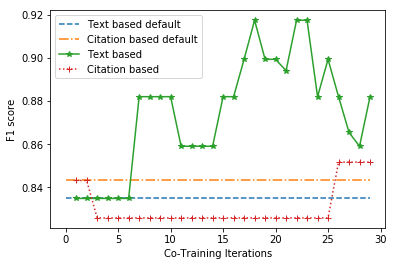

Self labeled pos size:  56
Self labeled neg size:  57
y1 disagree on 1  Proba:  [0.8039 0.1961]
y2 not aggreed on  1 Proba:  [0.2927 0.7073]
product probas: [0.23529799695058198, 0.13867251028724928]
result 0
y1 disagree on 15  Proba:  [0.2512 0.7488]
y2 not aggreed on  15 Proba:  [0.7012 0.2988]
product probas: [0.17617416392299304, 0.2237287061955979]
result 1
y1 disagree on 23  Proba:  [0.6481 0.3519]
y2 not aggreed on  23 Proba:  [0.0041 0.9959]
product probas: [0.002665511178843867, 0.3504262502151168]
result 1
y1 disagree on 41  Proba:  [0.7186 0.2814]
y2 not aggreed on  41 Proba:  [0.2927 0.7073]
product probas: [0.2103280722902467, 0.19901778595139857]
result 0
y1 disagree on 61  Proba:  [0.6457 0.3543]
y2 not aggreed on  61 Proba:  [0.1691 0.8309]
product probas: [0.10920330449089982, 0.29437190884191505]
result 1
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.95      0.98      0.97        62

 

In [105]:
import collections
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

np.set_printoptions(precision=4, suppress=True)

# fix random seed for reproducibility
np.random.seed(1)

# loop through all files in directory add name to name list
fileDir = "../../Data/"+Dataset+"/canopies/"
listfiles = os.listdir(fileDir)

co_lr_diff_embedding_result = []

# ------------ view two citation is fix, so move out to save time ------- #
# # read viewtwo embedding
# print("Load citation embedding: ", pp_citation)
# viewtwo_citation_embedding = com_func.read_all_citation_embedding_sorted(emb_type = pp_citation)

#---------------- load different embeddings for view one ---------------#
for select_emb in pp_textual:
#     print("Load textual embedding: ", select_emb)
#     # read viewone embeddings
#     viewone_textual_emb = com_func.read_all_textual_embedding_sorted(emb_type=select_emb, training_size = "3m")
    
#     print(viewone_textual_emb[0])
#     print(viewtwo_citation_embedding[0])
    
    threshold_change_all_co_lr_f1s = []
    threshold_change = []
    
    # -------------- different threshold (step by 10) -----------------------#
    for step_threshold in range(threshold_lower, threshold_upper, 10):
        threshold_change.append(step_threshold)
        # collect statistic to output
        allname, positive_sample_size, negative_sample_size  = ([] for i in range(3))
        all_labeled_count, unlabeled_count = ([] for i in range(2))

        all_co_LR_accuracy, all_co_LR_f1 = ([] for i in range(2))

        total_selected_group = 0

        # ------- different name group in all name group --------------------#
        for file in listfiles:
            # group name
            temp = file.split("_")
            name = temp[1]+"_"+temp[-1]
            print("For name: ",name)
            # read pid and aid from file
            data = read_file(fileDir+file)
            labeled_mask = data["authorID"] != "-1"
            labeled_data = data[labeled_mask]
            unlabeled_mask = data["authorID"] == "-1"
            ublabeled_data = data[unlabeled_mask]
            unlabeled_pid = ublabeled_data["paperID"].tolist()
            print(labeled_data.shape)
            # ---------------- collect all labeled sample -------------------- #
            # ---------------- if use all samples as negative --------------- #
            all_labeled_samples = labeled_data["paperID"].tolist()
            authorCounter = com_func.select_productive_groups(labeled_data, threshold_select_name_group)
            # if only have one class or no class pass the threshold, not applicable
            if(len(authorCounter)==0) or (len(authorCounter)==1):
                print(name," pass")
            else:
                total_selected_group+= 1
                # --------------for each name group---------------- #
                if apply_threshold_to_sample == True:
                    # ---------- only use sample pass threshold ------- #
                    #-------- only select authors in name group are very productive (more than threshold)---------#
                    labeled_data, author_list, _= com_func.only_select_productive_authors(labeled_data, step_threshold)
                    # ----------------- if use filtered samples as negative  --------- #
                    filtered_all_labeled_samples = labeled_data["paperID"].tolist()
                else:
                    # ----------- use all sample in name group --------- #
                    author_list = com_func.productive_authors_list(labeled_data, step_threshold)
                    print(name, " name group sample size: ",labeled_data.shape)
                    
                # -------------- extract all samples for name group -------------- #
                # for each name group
                # read in labeled data
                labeled_viewone_textual = extract_embedding(viewone_textual_emb, labeled_data["paperID"])
                print(labeled_viewone_textual.shape)
                labeled_viewtwo_citation = extract_embedding(viewtwo_citation_embedding, labeled_data["paperID"])
                print(labeled_viewtwo_citation.shape)
                print("Labeled: ",len(labeled_viewone_textual), " : ", len(labeled_viewtwo_citation))

                # read in unlabeled data
                unlabeled_viewone_textual = extract_unlabeled_embedding(viewone_textual_emb, unlabeled_pid)
                print(unlabeled_viewone_textual.shape)
                unlabeled_viewtwo_citation = extract_unlabeled_embedding(viewtwo_citation_embedding, unlabeled_pid)
                print(unlabeled_viewtwo_citation.shape)
                print("Unlabeled: ",len(unlabeled_viewone_textual), " : ", len(unlabeled_viewtwo_citation))
                
                # remove samples that have no citation link from ublabeled data
                noCitationPids_unlabeled = set(unlabeled_viewone_textual['paperID'])-set(unlabeled_viewtwo_citation['paperID'])
                print("Unlabeled no citation link size: ", len(noCitationPids_unlabeled))
                # process unlabeled data
                unlabeled_dv1 = unlabeled_viewone_textual[~unlabeled_viewone_textual['paperID'].isin(noCitationPids_unlabeled)].reset_index(drop=True)
                unlabeled_dv2 = unlabeled_viewtwo_citation
                
                # ---------------- shuffle the data ----------------- #
                labeled_data = labeled_data.sample(frac=1).reset_index(drop=True)
                # ------------------ alignment ---------------------- #
                labeled_viewone_textual = pd.merge(labeled_data, labeled_viewone_textual, left_on="paperID", right_on = [0], how = "left")
                labeled_viewtwo_citation = pd.merge(labeled_data, labeled_viewtwo_citation, left_on="paperID", right_on = [0], how = "left")
                labeled_viewtwo_citation.fillna(0, inplace=True)
                
                print(labeled_viewone_textual.shape)
                print(labeled_viewtwo_citation.shape)
                print(unlabeled_dv1.shape)
                print(unlabeled_dv2.shape)
                counter = 0
                # loop through each author
                for author in author_list:
                    all_labeled_count.append(len(labeled_data))
                    unlabeled_count.append(len(unlabeled_dv1))
                    author_name = name+'_'+str(counter)
                    allname.append(author_name)
                    print(author_name, " : ", author)
                    mask = labeled_data["authorID"] == author
                    temp = labeled_data[mask]
                    positive_sample_pid = temp["paperID"].tolist()
                    negative_sample_pid = extractNegativeSample(positive_sample_pid, filtered_all_labeled_samples)
                    
                    # save number of positive and negative samples
                    positive_sample_size.append(len(positive_sample_pid))
                    negative_sample_size.append(len(negative_sample_pid))
                    
                    # ----------------- generate binary label ------------------ #
                    # form positive and negative (negative class come from similar name group)
                    all_authors = []
                    all_authors.append(positive_sample_pid)
                    all_authors.append(negative_sample_pid)
                    appended_data = []
                    for label, pid in enumerate(all_authors):
                        # create df save one author data 
                        authordf = pd.DataFrame({"paperID":pid})
                        authordf['label'] = label
                        appended_data.append(authordf)
                    label_pid = pd.concat(appended_data, axis=0,ignore_index=True)
                    # ----------- alignment of label with input data ------------ #
                    label_pid = pd.merge(labeled_viewone_textual["paperID"].to_frame(), label_pid, on = "paperID")
                    #------------- process data for k-fold cv ------------------- #
                    # throw away some column for labeled data
                    labeled_dv1 = labeled_viewone_textual.drop(["authorID", 0], axis=1)
                    labeled_dv2 = labeled_viewtwo_citation.drop(["authorID", 0], axis=1)
                    # merge label into data
                    labeled_dv1 = pd.merge(labeled_dv1, label_pid, on = "paperID")
                    labeled_dv2 = pd.merge(labeled_dv2, label_pid, on = "paperID")
                    label = label_pid.drop(["paperID"], axis=1)
                    # ----------- check the final inputs------------------ #
#                     print(labeled_dv1.head())
#                     print(unlabeled_dv1.head())
                    # ------------ fit co-training model with k-fold ------------------------ #
                    co_logistic_clf = Co_training_clf(clf1=LogisticRegression(solver= "liblinear"),p=1,n=1, k=30)
                    co_lr_accuracy, co_lr_f1 = k_fold_cv_co_train_binary(labeled_dv1, labeled_dv2, 
                                                                         unlabeled_dv1, unlabeled_dv2,
                                                                         label, co_logistic_clf, 10, author_name, select_emb)
                    
                    all_co_LR_accuracy.append(co_lr_accuracy)
                    all_co_LR_f1.append(co_lr_f1)
                    counter+=1
                    break
                break
                    
#         # write evaluation result to excel
#         output = pd.DataFrame({'Author Name':allname, "positive sample size":positive_sample_size,"negative sample size":negative_sample_size, 
#                                "labeled sample size": all_labeled_count, "unlabeled sample size": unlabeled_count, 
#                                "co_logisticRegression Accuracy":all_co_LR_accuracy, "co_logisticRegression F1": all_co_LR_f1})
#         savePath = "../../result/"+Dataset+"/co_train_binary/"
#         filename = "(Global emb sample 3m) viewone_textual="+select_emb+"_viewtwo_citation="+pp_citation+"_threshold="+str(step_threshold)+"_namegroupcount="+str(total_selected_group)+".csv"
#         com_func.write_csv_df(savePath, filename, output)
#         print("Done")
        
#         threshold_change_all_co_lr_f1s.append(all_co_LR_f1)
        
#     co_lr_diff_embedding_result.append(threshold_change_all_co_lr_f1s)

In [46]:
from statistics import mean 

print(threshold_change_all_co_lr_f1s)
print(co_lr_diff_embedding_result)

[]
[]


In [ ]:
# %whos
del viewtwo_citation_embedding
del viewone_textual_emb